In [75]:
# importing libraries for feature extracting and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
import scipy
from sklearn.preprocessing import OneHotEncoder
from mlxtend.plotting import plot_decision_regions
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import librosa.display
#Keras for building our neural network
import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [64]:
#function for calculating fourier transform
def fft_plot(audio1,sampling_rate,genre):
    n1=len(audio1)
    T=1/sampling_rate;
    yf1=scipy.fft(audio1)
    xf1=np.linspace(0.0,1.0/(2.0*T),n1//2)
    fig,ax=plt.subplots()
    ax.plot(xf1,2.0/n1*np.abs(yf1[:n1//2]),color='r')
    ax.set_xlim([0,2000])
    plt.grid()
    plt.xlabel("Frequency")
    plt.ylabel("Mag")
    plt.savefig(f'FourierTransform{genre}')
    plt.title(genre)

In [73]:
#Code for plotting the decision boundary using SVM
# a and b are the two features used to form the SVM
def svmplot(a,b):
    df=pd.read_csv('data.csv')
    X=df[[a,b]]
    X=X.to_numpy()
    scaler = StandardScaler().fit(X)
    genre_list = df.iloc[:, -1]
    encoder = LabelEncoder()
    y = encoder.fit_transform(genre_list)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    accuracy = float(cm.diagonal().sum())/len(y_test)
    print("\nAccuracy Of SVM For The Given Dataset : ", accuracy)
    plot_decision_regions(X,y, clf=svclassifier, legend=1)
    plt.title(f'{a} vs {b}')
    plt.xlabel(a)
    plt.ylabel(b)
    plt.savefig(f'SVM_{a}_VS_{b} ',bbox_inches='tight',pad_inches=0)
    plt.show()

In [109]:
#Cell to plot the Spectogram of the Audio Signal
def spec(songname):    
    x, sr = librosa.load(songname,duration=30)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.title("Classical")
    plt.colorbar()
    plt.savefig(f'spectogram',bbox_inches='tight',pad_inches=0)
    plt.show()    

In [66]:
# Function to perform Feature Extraction on the audio file. We can add our features if we want
def features(songname):
    y, sr = librosa.load(songname, mono=True)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    rmse=librosa.feature.rmse(y=y)
    to_append = f'{np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
    for e in mfcc:
        to_append += f' {np.mean(e)}'
    return to_append

In [16]:
#Making a file called data.csv to store the data extracted from the audio files
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
genres='classical rock'.split()
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [17]:
#Extracting data from our audio file and storing it in a file called data.csv
for g in genres:
    for filename in os.listdir(f'./{g}'):
        songname = f'{g}/{filename}'
        to_append=f'{filename} '
        to_append+=features(songname)
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [67]:
#Encoding the data in the form of 0s and 1s
df=pd.read_csv("data.csv")
df=df.drop('filename',axis=1)
genre_list = df.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)


In [68]:
y=y.reshape(-1,1)
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()


Accuracy Of SVM For The Given Dataset :  0.95


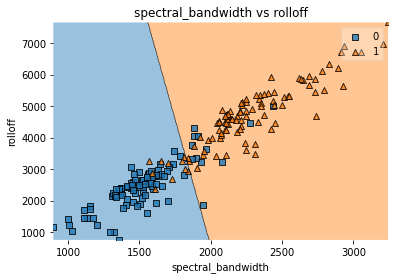

In [76]:
svmplot("spectral_bandwidth","rolloff")

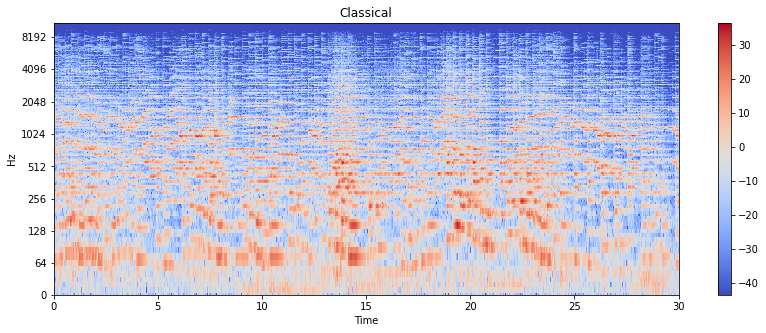

In [110]:
spec(r"C:\Users\HP\Documents\class.au")

In [43]:
#Scaling the data to optimise Gradient Descent used in the Neural Network
X=np.array(df.iloc[:, :-1],dtype=float)
scaler = StandardScaler().fit(X)
X = scaler.transform(np.array(df.iloc[:, :-1], dtype = float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [46]:
#Building our neural network
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=keras.regularizers.l2(l=0.1)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)))
model.add(layers.Dense(2, activation='softmax'))

In [47]:
#Specifying the parameters
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128)

Epoch 1/20
160/160 [==============================] - 0s 3ms/step - loss: 10.6824 - accuracy: 0.7063
Epoch 2/20
160/160 [==============================] - 0s 44us/step - loss: 10.3953 - accuracy: 0.7750
Epoch 3/20
160/160 [==============================] - 0s 56us/step - loss: 10.1182 - accuracy: 0.8562
Epoch 4/20
160/160 [==============================] - 0s 66us/step - loss: 9.8488 - accuracy: 0.9000
Epoch 5/20
160/160 [==============================] - 0s 44us/step - loss: 9.5869 - accuracy: 0.9250
Epoch 6/20
160/160 [==============================] - 0s 56us/step - loss: 9.3331 - accuracy: 0.9438
Epoch 7/20
160/160 [==============================] - 0s 44us/step - loss: 9.0854 - accuracy: 0.9500
Epoch 8/20
160/160 [==============================] - 0s 69us/step - loss: 8.8434 - accuracy: 0.9563
Epoch 9/20
160/160 [==============================] - 0s 69us/step - loss: 8.6076 - accuracy: 0.9563
Epoch 10/20
160/160 [==============================] - 0s 50us/step - loss: 8.3771 - accu

In [59]:
#Print accuracy on test data
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy of our model on test data is:', a*100)    

Accuracy of our model on test data is: 95.0


In [80]:
#Cell to test own personal songs
test_filepath=r"C:\Users\HP\Documents\test1.au"
test=features(test_filepath)
test=test.split()
my_test=np.array(test)

In [81]:
#Printing the results
my_test=my_test.reshape(-1,1)
my_test=my_test.transpose()
my_test=scaler.transform(my_test)
result=model.predict(my_test)
print(result)
if(result[0][0]>result[0][1]):
    print("classical")
else:
    print("rock")

[[0.59677845 0.4032215 ]]
classical
